<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/CNN_Kodunun_%C4%B0yile%C5%9Ftirilmesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from IPython import get_ipython
from IPython.display import display
import kagglehub
import shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.signal import butter, lfilter, get_window

# Hann penceresi örneği (gerekirse kullanabilirsiniz)
hann_window = get_window('hann', 128)

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, random_split
    from torcheeg.datasets import DREAMERDataset
    from torcheeg import transforms
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("PyTorch veya torcheeg kütüphanesi bulunamadı. Lütfen ortamınıza yükleyin veya alternatif bir yöntem kullanın.")


In [4]:
# Kaggle'dan veri setini indirin
path = kagglehub.dataset_download("phhasian0710/dreamer")
print("Path to dataset files:", path)

100%|██████████| 847M/847M [00:12<00:00, 73.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1


In [5]:
# Veri setini yükleyin ve ön işleme adımlarını uygulayın
dataset = DREAMERDataset(
    io_path='./dreamer_cnn_data',
    mat_path=f'{path}/DREAMER.mat',  # Kaggle'dan indirilen dosyanın yolu
    offline_transform=transforms.Compose([
        transforms.BaselineRemoval(),
        transforms.MeanStdNormalize(),
        transforms.To2d()
    ]),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-17 15:03:01] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_cnn_data.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_cnn_data.
[2024-12-17 15:03:01] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:  52%|█████▏    | 12/23 [02:51<02:57, 16.10s/it]/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[PROCESS]: 100%|██████████| 23/23 [05:34<00:00, 14.56s/it]
[2024-12-17 15:11:32] INFO (torcheeg/Ma

In [78]:
# Veri setini eğitim ve test olarak ayırın
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [80]:
# Veri yükleyicileri tanımlayın
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [81]:
# İyileştirilmiş EEG tabanlı CNN modeli
class EEGCNN(nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)

        # Sabit giriş boyutuyla tam bağlı katman
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # Boyut kontrolünü kaldırabiliriz
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [82]:
# Modeli, kaybı ve optimizasyonu tanımlayın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # CosineAnnealingLR ekleniyor

train_losses = []
test_losses = []
test_accuracies = []

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Debug print
        if i % 10 == 0:
            print(f"Batch {i}, Loss: {loss.item():.4f}")

    return running_loss / len(train_loader)

def test_model():
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds

In [83]:
weights = torch.tensor([1.5, 1.0]).to(device)  # Sınıf 0 için ağırlığı artırabilirsiniz
criterion = nn.CrossEntropyLoss(weight=weights)

In [84]:
# Eğitim döngüsü
# Eğitim döngüsü
epochs = 10
for epoch in range(epochs):
    train_loss = train_one_epoch()
    test_loss, test_acc, _, _ = test_model()
    scheduler.step()  # Scheduler'i her epoch sonunda ekleyin
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Batch 0, Loss: 0.7287
Batch 10, Loss: 0.6961
Batch 20, Loss: 0.6786
Batch 30, Loss: 0.6912
Batch 40, Loss: 0.6965
Batch 50, Loss: 0.6825
Batch 60, Loss: 0.6826
Batch 70, Loss: 0.7356
Batch 80, Loss: 0.6841
Batch 90, Loss: 0.6965
Batch 100, Loss: 0.6817
Batch 110, Loss: 0.6765
Batch 120, Loss: 0.7058
Batch 130, Loss: 0.6899
Batch 140, Loss: 0.7204
Batch 150, Loss: 0.6837
Batch 160, Loss: 0.6910
Batch 170, Loss: 0.6796
Batch 180, Loss: 0.7143
Batch 190, Loss: 0.6831
Batch 200, Loss: 0.6923
Batch 210, Loss: 0.7037
Batch 220, Loss: 0.6825
Batch 230, Loss: 0.7369
Batch 240, Loss: 0.7986
Batch 250, Loss: 0.6690
Batch 260, Loss: 0.6747
Batch 270, Loss: 0.6765
Batch 280, Loss: 0.7625
Batch 290, Loss: 0.6796
Batch 300, Loss: 0.6670
Batch 310, Loss: 0.6870
Batch 320, Loss: 0.6828
Batch 330, Loss: 0.6910
Batch 340, Loss: 0.6847
Batch 350, Loss: 0.6973
Batch 360, Loss: 0.7128
Batch 370, Loss: 0.6940
Batch 380, Loss: 0.6376
Batch 390, Loss: 0.7378
Batch 400, Loss: 0.6973
Batch 410, Loss: 0.6901
Bat

Final Test Accuracy: 0.7311
Confusion Matrix:
 [[4685 2075]
 [2537 7852]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67      6760
           1       0.79      0.76      0.77     10389

    accuracy                           0.73     17149
   macro avg       0.72      0.72      0.72     17149
weighted avg       0.73      0.73      0.73     17149



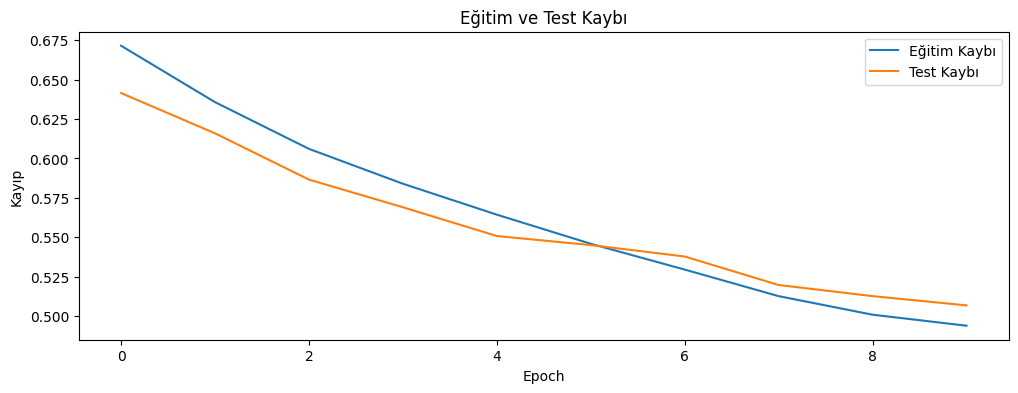

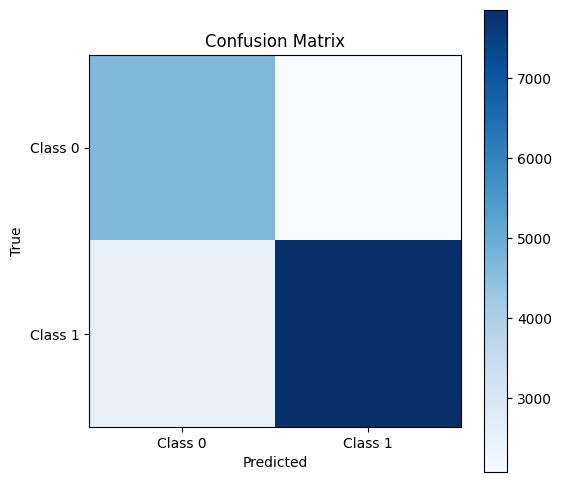

In [85]:
# Sonuçları tekrar test edip raporla
test_loss, test_acc, all_labels, all_preds = test_model()
print(f"Final Test Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

def plot_results(labels, preds, train_losses, test_losses):
    # Basitleştirilmiş grafik fonksiyonu
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(labels, preds)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(all_labels, all_preds, train_losses, test_losses)

In [86]:
print(f"Toplam veri sayısı: {len(train_loader.dataset)}")
print(f"Toplam batch sayısı (train): {len(train_loader)}")

Toplam veri sayısı: 68595
Toplam batch sayısı (train): 2144
